In [1]:

from datetime import datetime
import time
import os
from tqdm import tqdm
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import jieba.posseg as jp,jieba
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib

D:\ML_ENVS\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\ML_ENVS\lib\site-packages\gensim\corpora\dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
D:\ML_ENVS\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [10]:
def extract_info(x):

    CreationDate = re.findall(r'CreationDate = (.*?)//',x)[0]

    Title = re.findall(r'Title = (.*?)//',x)[0]

    Tags = re.findall(r'Tags = (.*?)//',x)[0]
    Tags = Tags.split('><')
    Tags[0] = Tags[0].lstrip('<')
    Tags[-1] = Tags[-1].rstrip('>')
    Tags = ' '.join(Tags)

    Score = re.findall(r'Score = (.*?)//',x)[0]


    AnswerCount = re.findall(r'AnswerCount = (.*?)//',x)
    if AnswerCount==[] or AnswerCount==['']:
        AnswerCount = re.findall(r'AnswerCount = (.*?)\n',x)
        if AnswerCount == [] or AnswerCount==['']:
            AnswerCount = None
        else:
            AnswerCount = AnswerCount[0]
    else:
        AnswerCount = AnswerCount[0]


    CommentCount = re.findall(r'CommentCount = (.*?)//',x)
    if CommentCount==[] or CommentCount==['']:
        CommentCount = re.findall(r'CommentCount = (.*?)\n',x)
        if CommentCount==[] or CommentCount==['']:
            CommentCount = None
        else:
            CommentCount = CommentCount[0]
    else:
        CommentCount = CommentCount[0]

    FavoriteCount = re.findall(r'FavoriteCount = (.*?)//',x)
    if FavoriteCount==[] or FavoriteCount==['']:
        FavoriteCount = re.findall(r'FavoriteCount = (.*?)\n',x)
        if FavoriteCount==[] or FavoriteCount==['']:
            FavoriteCount = None
        else:
            FavoriteCount = FavoriteCount[0]
    else:
        FavoriteCount = FavoriteCount[0]



    return CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount

In [11]:
new_df = pd.DataFrame({'CreationDate':[],'Title':[], 'Tags':[],
                          'Score':[],'AnswerCount':[], 'CommentCount':[],
                          'FavoriteCount':[]})

CreationDate_list = []
Title_list = []
Tags_list = []
Score_list = []
AnswerCount_list = []
CommentCount_list = []
FavoriteCount_list = []


with open('./sse is equal to 1.16.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    print(len(lines))
    lines = list(set(lines))
    print(len(lines))
    # assert 1==2
    for l in lines:

        CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount = extract_info(l)
        CreationDate_list.append(CreationDate)
        Title_list.append(Title)
        Tags_list.append(Tags)
        Score_list.append(Score)
        AnswerCount_list.append(AnswerCount)
        CommentCount_list.append(CommentCount)
        FavoriteCount_list.append(FavoriteCount)
            # new_df.loc[len(new_df)] = [CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount]


new_df['CreationDate'] = CreationDate_list
new_df['Title'] = Title_list
new_df['Tags'] = Tags_list
new_df['Score'] = Score_list
new_df['AnswerCount'] = AnswerCount_list
new_df['CommentCount'] = CommentCount_list
new_df['FavoriteCount'] =FavoriteCount_list

# new_df = new_df.drop_duplicates()
df1 = new_df
df1.info()
df1.head(2)

df1['Tags'] = df1['Tags'].apply(lambda x: x.replace('java', ''))
df1.head(2)

16
16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CreationDate   16 non-null     object
 1   Title          16 non-null     object
 2   Tags           16 non-null     object
 3   Score          16 non-null     object
 4   AnswerCount    16 non-null     object
 5   CommentCount   16 non-null     object
 6   FavoriteCount  3 non-null      object
dtypes: object(7)
memory usage: 1.0+ KB


,CreationDate,Title,Tags,Score,AnswerCount,CommentCount,FavoriteCount
0,2017-06-03T16:59:14.590,Swagger UI Bad Request URL Generation,spring swagger swagger-ui springfox,1,1,1,1
1,2018-05-23T10:23:39.823,How do you reference a Component from one fram...,,0,0,4,None


In [12]:
text = df1['Title'] + pd.Series([' ']*len(df1)) + df1['Tags']
text = text.to_list()
print(len(text))
text[:5]

16


['Swagger UI Bad Request URL Generation  spring swagger swagger-ui springfox',
 'How do you reference a Component from one frame to be used in a different frame without using Static? ',
 'Log4j2 routing appender JavaScript config error script  logging log4j2 appender',
 'How can hide the textbox on basis on checkbox in JSP script  jquery jsp checkbox',
 'Getting Date as null when using java.sql.Date  spring']

In [13]:
import nltk
from nltk.corpus import stopwords
def separate_sentence(text):
    text = text.lower()
    remove_chars = '[·’!"\#$%&\'()＃！（）*+,.:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+'
    text = re.sub(remove_chars, "", text)

    disease_List = nltk.word_tokenize(text)

    filtered = [w for w in disease_List if(w not in stopwords.words('english'))]

    Rfiltered =nltk.pos_tag(filtered)

    filter_word = [i[0] for i in Rfiltered]
    return ' '.join(filter_word)

In [ ]:
separate_sentence(' [Fix-3616][Server] when worker akc/response master exception , async retry (#3776)')

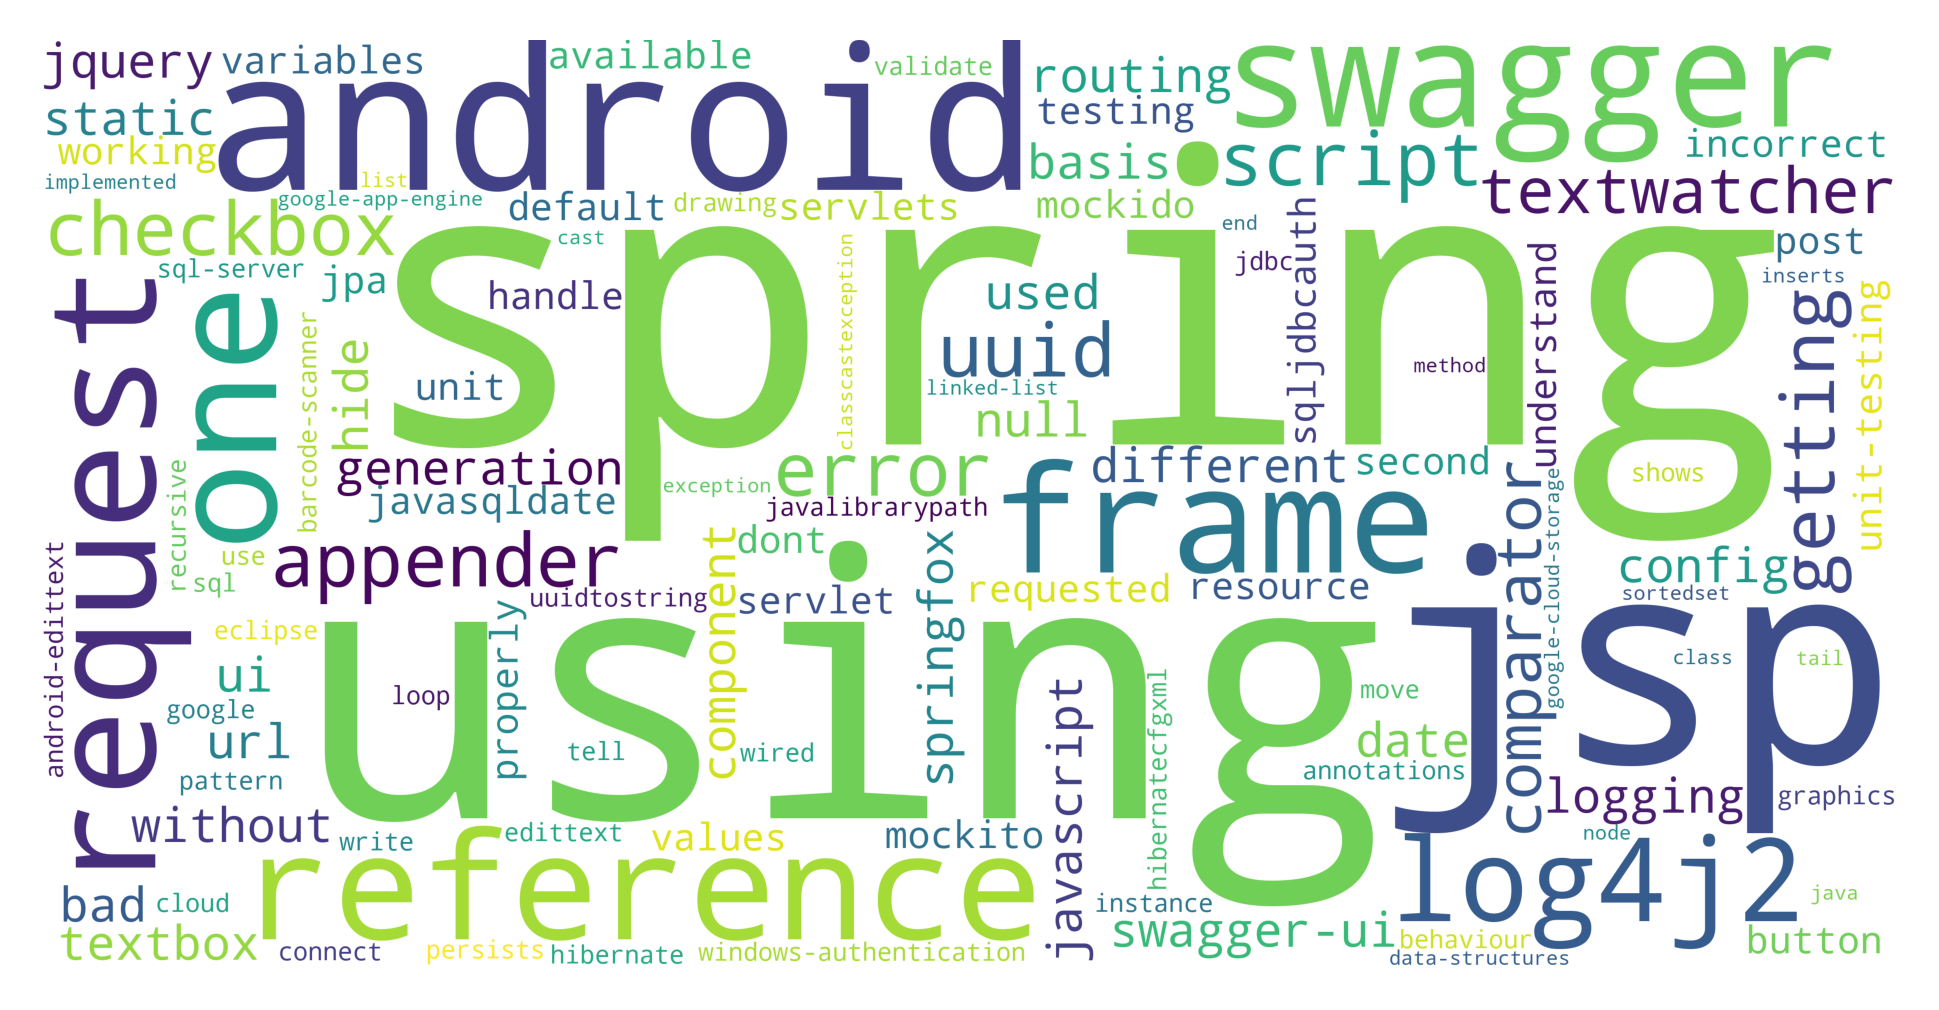

In [14]:
import wordcloud
import matplotlib.pyplot as plt

words_list = (' '.join([separate_sentence(i) for i in text])).split(' ')


dict = {}
for key in words_list:
    dict[key] = dict.get(key, 0) + 1
plt.figure(dpi=400)
wordcloud = wordcloud.WordCloud(height=2000,width=4000,background_color='white').fit_words(dict)


plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./pic/low_sse_wordclound.jpg',bbox_inches = 'tight')